### 02 – Capacity Fade Modeling & Feature Engineering

This notebook:
- Aggregates clean row-level data into per-cycle features
- Fits a semi-empirical √n capacity fade model
- Estimates End-of-Life (80% capacity)


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.feature_engineering import *
from src.preprocessing import *
from src.capacity_models import *


#### Load required cleaned CSv file

In [2]:
clean_df = pd.read_csv("../data/clean_rows.csv")
clean_df.head()


,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Temperature(℃),Date_Time,Cycle_Index,cell_id,Source_File,Test_Time_sec,Cycle_Index_Global
0,1,00:00:00,0.0,0.0,4.1902,0.0,NaN,2020-12-14 10:16:16,1,Cell_1,../data\LR1865SZ_cycles201214_002_4.xlsx,0.0,0
1,2,00:00:01,0.0,0.0,4.1902,0.0,NaN,2020-12-14 10:16:18,1,Cell_1,../data\LR1865SZ_cycles201214_002_4.xlsx,1.0,0
2,3,00:00:02,0.0,0.0,4.1893,0.0,NaN,2020-12-14 10:16:19,1,Cell_1,../data\LR1865SZ_cycles201214_002_4.xlsx,2.0,0
3,4,00:00:04,0.0,0.0,4.1905,0.0,NaN,2020-12-14 10:16:20,1,Cell_1,../data\LR1865SZ_cycles201214_002_4.xlsx,4.0,0
4,5,00:00:05,0.0,0.0,4.1902,0.0,NaN,2020-12-14 10:16:21,1,Cell_1,../data\LR1865SZ_cycles201214_002_4.xlsx,5.0,0


#### Calculating required features

In [3]:
NOMINAL_CAPACITY_AH = 2.0
current_col = "Current(A)"
voltage_col = "Voltage(V)"
capacity_col = "Capacity(Ah)"
temperature_col = "Temperature(℃)"

cycle_df = compute_cycle_features(
    df=clean_df,
    time_col="Test_Time_sec",
    nominal_capacity_ah=NOMINAL_CAPACITY_AH,
    current_col=current_col,
    voltage_col=voltage_col,
    capacity_col=capacity_col,
    temperature_col=temperature_col,  # can be None
)

cycle_df


,cell_id,Cycle,C_rate_mean,C_rate_max,Charge_Ah,Discharge_Ah,Coulombic_Efficiency_%,Cycle_Duration_s,Energy_Throughput_Wh,Temp_Min_C,Temp_Mean_C,Temp_Max_C,Num_points
0,Cell_1,0,1.775393,2.4040,0.000,2.264,NaN,2296.0,8.121953,NaN,NaN,NaN,2258
1,Cell_1,1,1.942749,2.4040,1.672,1.687,100.897129,3116.0,12.649373,NaN,NaN,NaN,3078
2,Cell_1,2,1.937208,2.4040,1.666,1.662,99.759904,3093.0,12.522325,NaN,NaN,NaN,3057
3,Cell_1,3,1.934738,2.4040,1.647,1.644,99.817851,3064.0,12.371862,NaN,NaN,NaN,3036
4,Cell_1,4,1.927172,2.4040,1.633,1.627,99.632578,3043.0,12.263728,NaN,NaN,NaN,3008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Cell_2,96,1.196913,3.6025,0.298,0.296,99.328859,898.0,2.192159,NaN,NaN,NaN,899
198,Cell_2,97,1.175359,3.6025,0.293,0.289,98.634812,891.0,2.148035,NaN,NaN,NaN,894
199,Cell_2,98,1.156202,3.6025,0.283,0.281,99.293286,883.0,2.087534,NaN,NaN,NaN,884
200,Cell_2,99,1.111593,3.6025,0.272,0.269,98.897059,871.0,1.984360,NaN,NaN,NaN,871


#### Filtering the anamalous data points

In [4]:
filtered_cycles_df = filter_cycle_features(cycle_df)
filtered_cycles_df

,cell_id,Cycle,C_rate_mean,C_rate_max,Charge_Ah,Discharge_Ah,Coulombic_Efficiency_%,Cycle_Duration_s,Energy_Throughput_Wh,Temp_Min_C,Temp_Mean_C,Temp_Max_C,Num_points,Delta_Q
0,Cell_1,3,1.934738,2.4040,1.647,1.644,99.817851,3064.0,12.371862,NaN,NaN,NaN,3036,-0.018
1,Cell_1,4,1.927172,2.4040,1.633,1.627,99.632578,3043.0,12.263728,NaN,NaN,NaN,3008,-0.017
2,Cell_1,5,1.923338,2.4040,1.625,1.621,99.753846,3031.0,12.204228,NaN,NaN,NaN,3014,-0.006
3,Cell_1,6,1.923510,2.4040,1.607,1.601,99.626633,3004.0,12.060152,NaN,NaN,NaN,2990,-0.020
4,Cell_1,7,1.918332,2.4040,1.598,1.590,99.499374,2988.0,11.990072,NaN,NaN,NaN,2958,-0.011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Cell_2,95,1.198089,3.6015,0.299,0.297,99.331104,898.0,2.198632,NaN,NaN,NaN,901,-0.002
190,Cell_2,96,1.196913,3.6025,0.298,0.296,99.328859,898.0,2.192159,NaN,NaN,NaN,899,-0.001
191,Cell_2,97,1.175359,3.6025,0.293,0.289,98.634812,891.0,2.148035,NaN,NaN,NaN,894,-0.007
192,Cell_2,98,1.156202,3.6025,0.283,0.281,99.293286,883.0,2.087534,NaN,NaN,NaN,884,-0.008


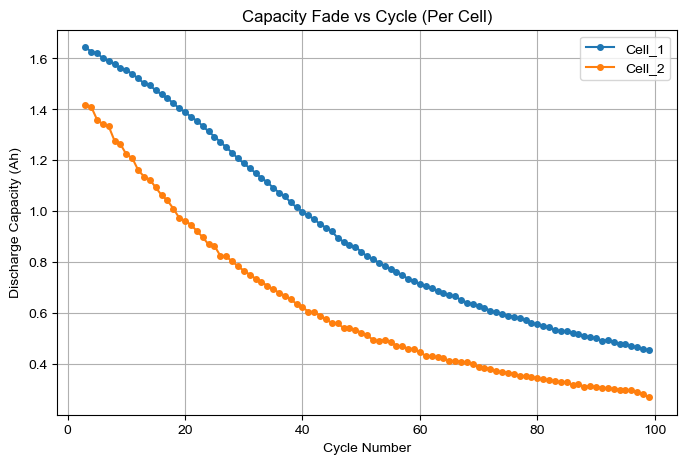

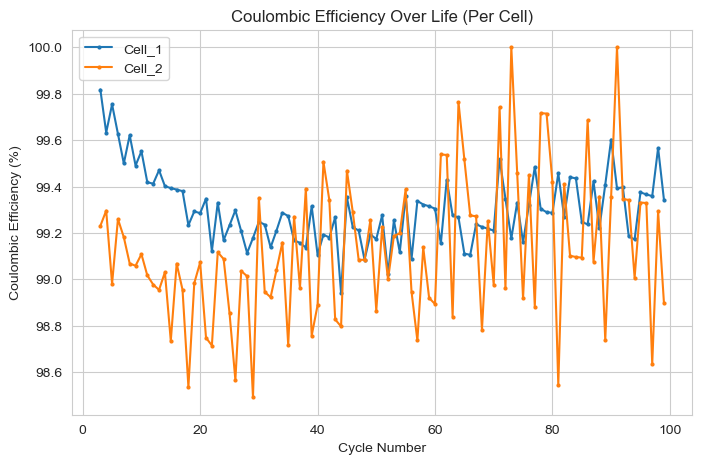

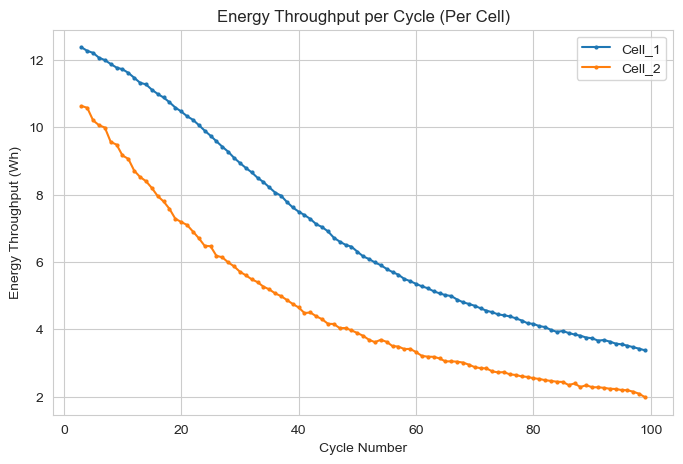

In [5]:
# ---------------------------------------
# 1. Plot Capacity Fade (per cell)
# ---------------------------------------
plt.figure(figsize=(8,5))

for cell_id, g in filtered_cycles_df.groupby("cell_id"):
    plt.plot(
        g["Cycle"], g["Discharge_Ah"],
        marker="o", linestyle="-", markersize=4,
        label=f"{cell_id}"
    )

plt.xlabel("Cycle Number")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("Capacity Fade vs Cycle (Per Cell)")
plt.grid(True)
plt.legend()
sns.set_style("whitegrid")
plt.show()


# ---------------------------------------
# 2. Plot Coulombic Efficiency (per cell)
# ---------------------------------------
plt.figure(figsize=(8,5))

for cell_id, g in filtered_cycles_df.groupby("cell_id"):
    plt.plot(
        g["Cycle"], g["Coulombic_Efficiency_%"],
        marker=".", linestyle="-", markersize=4,
        label=f"{cell_id}"
    )

plt.xlabel("Cycle Number")
plt.ylabel("Coulombic Efficiency (%)")
plt.title("Coulombic Efficiency Over Life (Per Cell)")
plt.grid(True)
plt.legend()
sns.set_style("whitegrid")
plt.show()


# ---------------------------------------
# 3. Plot Energy Throughput per Cycle
# ---------------------------------------
plt.figure(figsize=(8,5))

for cell_id, g in filtered_cycles_df.groupby("cell_id"):
    plt.plot(
        g["Cycle"], g["Energy_Throughput_Wh"],
        marker=".", linestyle="-", markersize=4,
        label=f"{cell_id}"
    )

plt.xlabel("Cycle Number")
plt.ylabel("Energy Throughput (Wh)")
plt.title("Energy Throughput per Cycle (Per Cell)")
plt.grid(True)
plt.legend()
sns.set_style("whitegrid")
plt.show()



=== Fitting models for Cell_1 ===


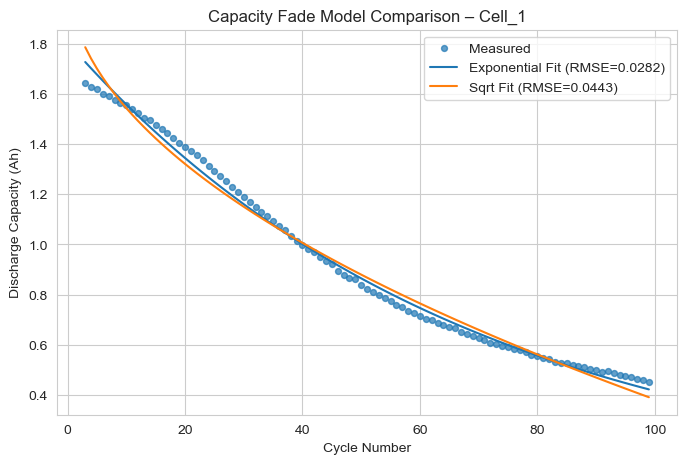


=== Fitting models for Cell_2 ===


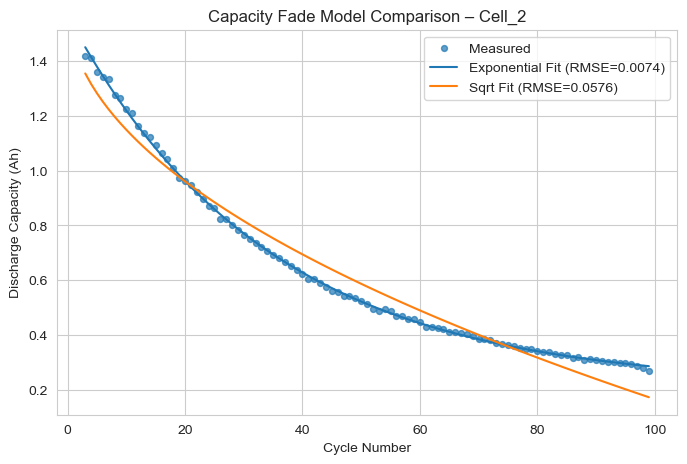

  cell_id  Q0_measured  Q_end_measured  exp_Q_inf    exp_Q0     exp_k  \
0  Cell_1        1.644           0.453   0.006834  1.804706  0.014798   
1  Cell_2        1.418           0.269   0.214771  1.563780  0.029550   

    sqrt_Q0    sqrt_a  rmse_exp  rmse_sqrt  
0  2.079547  0.169701  0.028248   0.044288  
1  1.602504  0.143577  0.007445   0.057635  


In [6]:
cells = filtered_cycles_df["cell_id"].unique()
model_summaries = []
final_result = []

for cell_id in cells:
    print(f"\n=== Fitting models for {cell_id} ===")

    result = fit_capacity_models(filtered_cycles_df, cell_id)

    n = result["n"]
    Q = result["Q"]
    Qexp  = result["Q_exp_fit"]
    Qsqrt = result["Q_sqrt_fit"]

    rmse_exp  = result["rmse_exp"]
    rmse_sqrt = result["rmse_sqrt"]

    Q_inf, Q0_exp, k = result["popt_exp"]
    Q0_sqrt, a = result["popt_sqrt"]

    model_summaries.append({
        "cell_id": cell_id,
        "Q0_measured": result["Q"][0],
        "Q_end_measured": result["Q"][-1],
        "exp_Q_inf": Q_inf,
        "exp_Q0": Q0_exp,
        "exp_k": k,
        "sqrt_Q0": Q0_sqrt,
        "sqrt_a": a,
        "rmse_exp": rmse_exp,
        "rmse_sqrt": rmse_sqrt,
    })

    final_result.append(
        pd.DataFrame({
            "cell_id": cell_id,
            "Cycle": n,
            "Q_measured": Q,
            "Q_exp_fit": Qexp,
            "Q_sqrt_fit": Qsqrt,
        })
    )

    # --- Plot ---
    plt.figure(figsize=(8,5))
    plt.scatter(n, Q, s=18, label="Measured", alpha=0.7)
    plt.plot(n, Qexp,  label=f"Exponential Fit (RMSE={rmse_exp:.4f})")
    plt.plot(n, Qsqrt, label=f"Sqrt Fit (RMSE={rmse_sqrt:.4f})")

    plt.xlabel("Cycle Number")
    plt.ylabel("Discharge Capacity (Ah)")
    plt.title(f"Capacity Fade Model Comparison – {cell_id}")
    plt.legend()
    plt.grid(True)
    plt.show()

model_summary_df = pd.DataFrame(model_summaries)
capacity_result_df = pd.concat(final_result, ignore_index=True)
print(model_summary_df)


In [8]:
cycle_df.to_csv("../data/before_filtered_cycle_features.csv", index=False)
filtered_cycles_df.to_csv("../data/filtered_cycle_features.csv", index=False)
capacity_result_df.to_csv("../data/capacity_model_params.csv", index=False)

print("Saved cycle features and model parameters.")


Saved cycle features and model parameters.


#### Explore differential voltage (dV/dQ) analysis to track electrode degradation signatures.

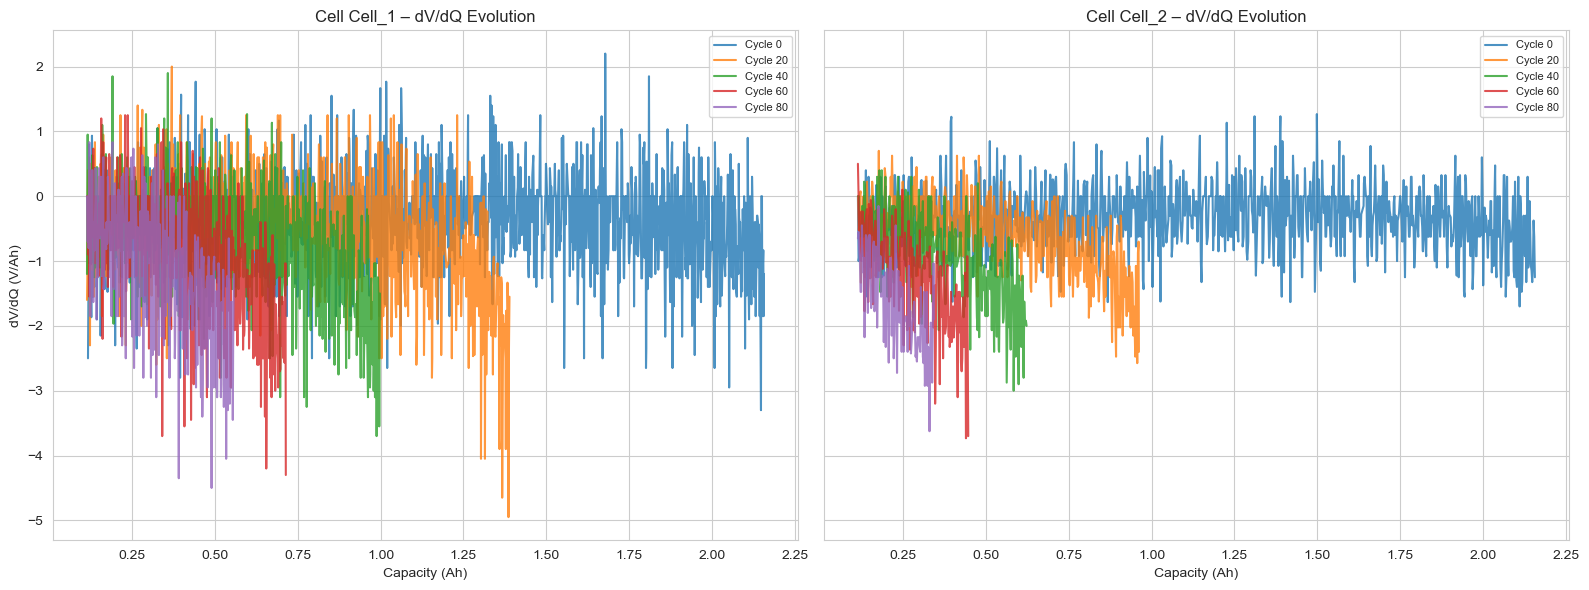

In [9]:
# select two cells
cell_ids = filtered_cycles_df["cell_id"].unique()[:2]
clean_filter_df = clean_df[(clean_df["Capacity(Ah)"]>0.05 * clean_df["Capacity(Ah)"].max()) & (clean_df["Capacity(Ah)"] < 0.95 * clean_df["Capacity(Ah)"].max())]

plot_dvdq_two_cells_side_by_side(
    df=clean_filter_df,
    cell_ids=cell_ids,
    cycle_col="Cycle_Index_Global",
    voltage_col=voltage_col,
    capacity_col=capacity_col,
    current_col=current_col,
    mode="discharge",
    n_cycles=6
)


C:\Users\iha81kor\Documents\LearningBattery\src\capacity_models.py:114: RuntimeWarning: divide by zero encountered in divide
  dvdq = dV / dQ


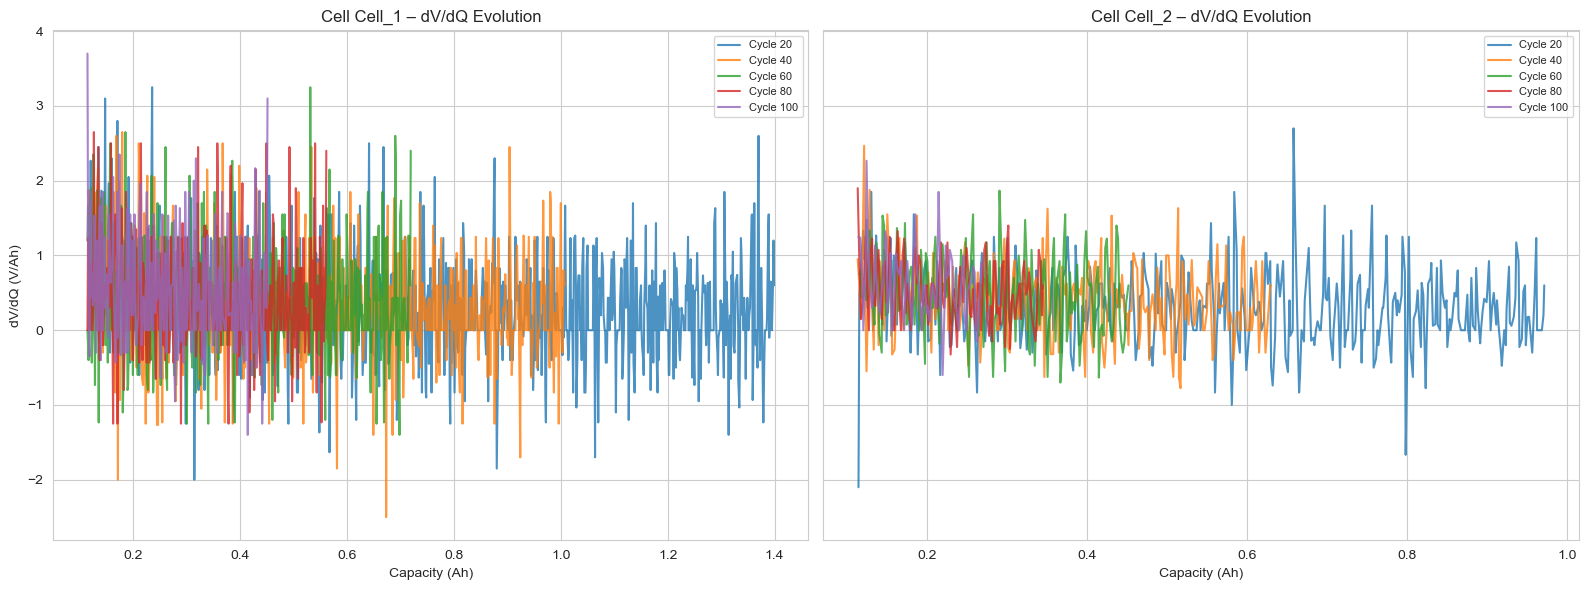

In [10]:
# select two cells
cell_ids = filtered_cycles_df["cell_id"].unique()[:2]

plot_dvdq_two_cells_side_by_side(
    df=clean_filter_df,
    cell_ids=cell_ids,
    cycle_col="Cycle_Index_Global",
    voltage_col=voltage_col,
    capacity_col=capacity_col,
    current_col=current_col,
    mode="charge",
    n_cycles=6
)

### Compare different modelling approaches

#### Statistical models vs physics informed models

In [82]:
stat_summaries = []

for cell_id in cycle_df["cell_id"].unique():
    stat_res = fit_statistical_models(cycle_df, cell_id)
    phys_res = fit_capacity_models(cycle_df, cell_id)

    stat_summaries.append({
        "cell_id": cell_id,
        "rmse_linear": stat_res["rmse_lin"],
        "rmse_poly": stat_res["rmse_poly"],
        "rmse_exp": phys_res["rmse_exp"],
        "rmse_sqrt": phys_res["rmse_sqrt"],
    })

compare_models_df = pd.DataFrame(stat_summaries)
print(compare_models_df)


  cell_id  rmse_linear  rmse_poly  rmse_exp  rmse_sqrt
0  Cell_1     0.102702   0.068131  0.067799   0.066606
1  Cell_2     0.155567   0.089048  0.072018   0.085927


#### Physics-informed models vs Machine learning regression

In [80]:
ml_summaries = []

for cell_id in cycle_df["cell_id"].unique():
    res = fit_ml_regressor(cycle_df, cell_id, min_samples=10)
    if res is None:
        continue

    phys = fit_capacity_models(filtered_cycles_df, cell_id)

    ml_summaries.append({
        "cell_id": cell_id,
        "samples": res["n_samples"],
        "features_used": res["features_used"],
        "rmse_rf": res["rmse_rf"],
        "rmse_exp": phys["rmse_exp"],
        "rmse_sqrt": phys["rmse_sqrt"]
    })

ml_compare_df = pd.DataFrame(ml_summaries)
print(ml_compare_df)

  cell_id  samples                                      features_used  \
0  Cell_1      101  [Cycle, C_rate_mean, C_rate_max, Energy_Throug...   
1  Cell_2      101  [Cycle, C_rate_mean, C_rate_max, Energy_Throug...   

    rmse_rf  rmse_exp  rmse_sqrt  
0  0.210805  0.028248   0.044288  
1  0.235636  0.007445   0.057635  
